<a href="https://colab.research.google.com/github/kabashiy/mysite/blob/master/transfer_entropy_EM_laplace_laplace_path_sampling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

(pip|conda) install numbaが必要.  
numbaのバージョンが古くてもだめな可能性高め.  
コンパイルは結構時間かかる.  

In [60]:
from google.colab import drive
drive.mount('/content/drive')

import sys
sys.path.append('/content/drive/My Drive/Colab Notebooks/my-modules')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [61]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
from scipy.linalg import inv 
import seaborn as sns

from numba import jit, f8, njit, prange
import numba_scipy

%matplotlib inline


In [62]:
shc_raw = pd.read_csv("data/01_SHC-ERK_HRG_MCF/raw_SHC.csv")
shc_raw = shc_raw.set_index("time")
shc_raw = shc_raw.replace(0.0, np.nan)
shc_raw = shc_raw.fillna(shc_raw.dropna().mean(axis=0)) #これには欠損値なし
#s = np.log((shc_raw/shc_raw.iloc[0:3].mean()).drop(index=[-3,-1.5])).to_numpy()
s_tmp = (shc_raw/shc_raw.iloc[0:3].mean())
s = np.log(s_tmp).to_numpy()


erk_raw = pd.read_csv("data/01_SHC-ERK_HRG_MCF/raw_ERK.csv")
erk_raw = erk_raw.set_index("time")
erk_raw = erk_raw.replace(0.0, np.nan)
erk_raw = erk_raw.fillna(erk_raw.dropna().mean(axis=0)) 
#e = np.log((erk_raw/erk_raw.iloc[0:3].mean()).drop(index=[-3,-1.5])).to_numpy()
e_tmp = (erk_raw/erk_raw.iloc[0:3].mean())
e = np.log(e_tmp).to_numpy()

"""
shc_raw = pd.read_csv("data/02_SHC-Grb2_HRG_MCF/raw_SHC.csv")
shc_raw = shc_raw.set_index("time")
shc_raw = shc_raw.replace(0.0, np.nan)
shc_raw = shc_raw.fillna(shc_raw.dropna().mean(axis=0))
#s = np.log((shc_raw/shc_raw.iloc[0:3].mean()).drop(index=[-3,-1.5])).to_numpy()
s_tmp = (shc_raw/shc_raw.iloc[0:3].mean())
s = np.log(s_tmp).to_numpy()



grb2_raw = pd.read_csv("data/02_SHC-Grb2_HRG_MCF/raw_Grb2.csv")
grb2_raw = grb2_raw.set_index("time")
grb2_raw = grb2_raw.replace(0.0, np.nan)
grb2_raw = grb2_raw.fillna(grb2_raw.dropna().mean(axis=0))
#e = np.log((grb2_raw/grb2_raw.iloc[0:3].mean()).drop(index=[-3,-1.5])).to_numpy()
e_tmp = (grb2_raw/grb2_raw.iloc[0:3].mean())
e = np.log(e_tmp).to_numpy()
"""

"""
grb2_raw = pd.read_excel("data/03_Grb2-ERK_HRG_MCF/Grb2-ERK.xlsx",sheet_name='Grb2')
grb2_raw = grb2_raw.set_index("time")
grb2_raw = grb2_raw.replace(0.0, np.nan)
grb2_raw = grb2_raw.fillna(grb2_raw.dropna().mean(axis=0))
s = np.log((grb2_raw/grb2_raw.iloc[0:3].mean())).to_numpy()

erk_raw = pd.read_excel("data/03_Grb2-ERK_HRG_MCF/Grb2-ERK.xlsx",sheet_name='ERK')
erk_raw = erk_raw.set_index("time")
erk_raw = erk_raw.replace(0.0, np.nan)
erk_raw = erk_raw.fillna(erk_raw.dropna().mean(axis=0))
e = np.log((erk_raw/erk_raw.iloc[0:3].mean())).to_numpy()
"""



T = len(s)
M = len(s.T)

FileNotFoundError: ignored

In [63]:
# 人工データの生成
mu1 = 0.4
mu2 = 0.4
sigma1 = 0.1
sigma2 = 0.2
a = 0.6
b = -0.3#-0.7#-0.3#-0.7
c = 0.6#0.8#0.6#0.8
d = 0.7
b_tmp = np.copy(b)

T = 100
M = 25

x_t = np.zeros((T,M))
y_t = np.zeros((T,M))
x = np.random.randn(M)*sigma1 + mu1
y = np.random.randn(M)*sigma2 + mu2
x_t[0] = x
y_t[0] = y
for t in range(1,T):

   
    #"""
    if t < T//2:
        pass
    else:
        b_tmp = 0.
    #"""

    x = a*x_t[t-1] + b_tmp*y_t[t-1] +mu1*np.ones(M)+sigma1*np.random.randn(M)
    x_t[t] = x 
    y = c*x_t[t-1] + d*y_t[t-1] +mu2*np.ones(M)+sigma2*np.random.randn(M)
    y_t[t] = y

        
    
s = x_t
e = y_t
T = len(x_t)



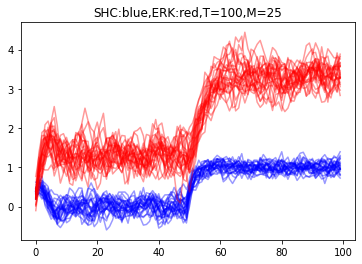

In [ ]:
## 確認用
plt.title('SHC:blue,ERK:red,T='+str(T)+',M='+str(M))
plt.plot(s,alpha=0.4,color='blue')
plt.plot(e,alpha=0.4,color='red')
plt.show()

In [64]:
# 必要な関数の定義
@jit('f8(f8[:],f8,f8,f8,f8)',nopython=True,cache=True)
def log_likelihood_x(theta,x_u,x_past_u,y_past_u,sigma_x):
    a_t = theta[0]
    b_t = theta[1]
    mu_t_x = theta[4]
    return -np.abs(x_u - a_t*x_past_u-b_t*y_past_u-mu_t_x)/sigma_x - np.log(sigma_x)-np.log(2)

@jit('f8(f8[:],f8,f8,f8,f8)',nopython=True,cache=True)
def log_likelihood_y(theta,y_u,x_past_u,y_past_u,sigma_y):
    c_t = theta[2]
    d_t = theta[3]
    mu_t_y = theta[5]
    return -np.abs(y_u - c_t*x_past_u-d_t*y_past_u-mu_t_y)/sigma_y - np.log(sigma_y)-np.log(2)

@jit('f8(f8[:],f8,f8,f8)',nopython=True,cache=True)
def abs_error_x(theta,x_u,x_past_u,y_past_u):
    a_t = theta[0]
    b_t = theta[1]
    mu_t_x = theta[4]
    return np.abs(x_u - a_t*x_past_u-b_t*y_past_u-mu_t_x)

@jit('f8(f8[:],f8,f8,f8)',nopython=True,cache=True)
def abs_error_y(theta,y_u,x_past_u,y_past_u):
    c_t = theta[2]
    d_t = theta[3]
    mu_t_y = theta[5]
    return np.abs(y_u - c_t*x_past_u-d_t*y_past_u-mu_t_y)




@jit('f8[:](f8[:,:],f8[:],f8[:],f8[:],f8[:],i8,i8,f8,f8)',nopython=True,cache=True,parallel=True)
def log_likelihood(theta_ens,x_t,y_t,x_t_past,y_t_past,N_ens,M,sigma_x,sigma_y):
    alpha_ens = np.zeros(N_ens)
    for i in prange(N_ens):
        theta_tmp = np.copy(theta_ens[i])
        alpha_i_tmp = 0.
        for m in prange(M):
            x_tm = 0.
            x_tm += x_t[m]
            y_tm = 0.
            y_tm += y_t[m]
            x_past_m = 0.
            x_past_m += x_t_past[m]
            y_past_m = 0.
            y_past_m += y_t_past[m]
            alpha_i_tmp += log_likelihood_x(theta_tmp,x_tm,x_past_m,y_past_m,sigma_x)+\
            log_likelihood_y(theta_tmp,y_tm,x_past_m,y_past_m,sigma_y)
        alpha_ens[i] = alpha_i_tmp 
    return alpha_ens


@jit('i8[:](f8[:])',nopython=True,parallel=True,cache=True)
def resampling(weight):
    N = weight.size
    weight_index = np.argsort(weight)
    weight_sorted = np.sort(weight)
    resampling_index = np.zeros(N)
    cumsum = np.empty(N)
    tmp = 0.
    for i in range(N):
        tmp += weight_sorted[i]
        cumsum[i] = tmp
    cumsum[-1] = 1.
    for i in prange(N):
        u = np.random.rand()
        resampling_index[i] = weight_index[(cumsum[cumsum<u]).size]
    return resampling_index.astype(np.int64)

@jit('i8[:](f8[:])',nopython=True,parallel=True,cache=True)
def residual_resampling(weight):
    ## https://arxiv.org/pdf/cs/0507025.pdf
    N = weight.size
    weight_index = np.argsort(weight)
    weight_sorted = np.sort(weight)
    resampling_index = np.zeros(N)
    weight_int = np.floor(weight_sorted*N).astype(np.int64)
    
    nonzero_counter = 0
    for i in range(N):
        for _ in range(weight_int[i]):
            resampling_index[nonzero_counter] = weight_index[i]
            nonzero_counter += 1
            
    
    weight_sorted = (N*weight_sorted-weight_int)/(N-np.sum(weight_int))

    
    cumsum = np.zeros(N)
    tmp = 0.
    for i in range(N):
        tmp += weight_sorted[i]
        cumsum[i] = tmp
    cumsum[-1] = 1.
    for i in prange(nonzero_counter,N):
        u = np.random.rand()
        resampling_index[i] = weight_index[(cumsum[cumsum<u]).size]
    return resampling_index.astype(np.int64)


    

In [65]:
## パラメータ推定用

def PF(theta_path,alpha_path,noise_path,index_path,x,y,N_ens,r,sigma_x,sigma_y):

    deg = 1
    M = x[0].size
    T = x.T[0].size
    d2 = 4*deg+2
    neg_log_marginal_likelihood = 0.

    
    theta_ens_ = np.zeros((N_ens,d2))
    noise = np.random.laplace(size=(N_ens,d2))*r
    theta_ens_[:,-2] += x[0].mean()
    theta_ens_[:,-1] += y[0].mean()
    theta_ens = theta_ens_+noise
    
    
    theta_path[0] = theta_ens_
    noise_path[0]  = noise


    alpha_ens = np.ones(N_ens)/N_ens
    alpha_ens_ = np.ones(N_ens)/N_ens
    alpha_path[0] = np.ones(N_ens)/N_ens
    resampling_index = np.random.permutation(np.array(range(N_ens)))
    index_path[0] = resampling_index
    

    ## PF本体
    for t in range(1,T):
        
        x_t = np.copy(x)[t]
        y_t = np.copy(y)[t]
        x_t_past = np.copy(x)[t-1]
        y_t_past = np.copy(y)[t-1]
        
    
        alpha_ens = log_likelihood(theta_ens,x_t,y_t,x_t_past,y_t_past,N_ens,M,sigma_x,sigma_y)
        
        alpha_max = alpha_ens.max()
        ## logsumexpはscipy.specialなので
        const = np.log(np.sum(np.exp(alpha_ens - alpha_max)))
        alpha_ens_ = np.exp(alpha_ens  - alpha_max - const)
        alpha_path[t] = alpha_ens_

        
        alpha_max = alpha_ens.max()
        neg_log_marginal_likelihood += -np.log(np.sum(np.exp(alpha_ens - alpha_max)))-alpha_max
        
        resampling_index_prev = np.copy(resampling_index)
        resampling_index = residual_resampling(alpha_ens_)
        theta_ens_prev = np.copy(theta_ens_)
        theta_ens_ = theta_ens[resampling_index]
        
        
        index_path[t] = resampling_index

        theta_path[t] = theta_ens_
        
        noise = np.random.laplace(size=(N_ens,d2))*r
        theta_ens = theta_ens_+noise
        noise_path[t] = noise

        
    return neg_log_marginal_likelihood

In [66]:
##サロゲートも出す
def PF_generator(x_v_path,y_v_path,theta_path,alpha_path,index_path,x,y,N_ens,r,sigma_x,sigma_y):

    deg = 1
    M = x[0].size
    T = x.T[0].size
    d2 = 4*deg+2
    
    neg_log_marginal_likelihood = 0.
    theta_ens_ = np.zeros((N_ens,d2))
    theta_ens_[:,-2] += x[0].mean()
    theta_ens_[:,-1] += y[0].mean()
    theta_ens = theta_ens_ + np.random.laplace(size=(N_ens,d2))*r
    
    theta_path[0] = theta_ens_


    alpha_ens = np.zeros(N_ens)/N_ens
    alpha_ens_ = np.zeros(N_ens)/N_ens
    resampling_index = np.random.permutation(np.array(range(N_ens)))
    index_path[0] = resampling_index
    
    ##生成する x_t,y_t
    cor = (np.linalg.cholesky(np.cov(x[0],y[0])).T).dot(np.random.randn(2,N_ens))
    x_v = x[0].mean()+cor[0]
    y_v = y[0].mean()+cor[1]
    x_v_path[0] = x_v
    y_v_path[0] = y_v

    ## PF本体
    for t in range(1,T):
        
        x_t = np.copy(x)[t]
        y_t = np.copy(y)[t]
        x_t_past = np.copy(x)[t-1]
        y_t_past = np.copy(y)[t-1]
        
        
        alpha_ens = log_likelihood(theta_ens,x_t,y_t,x_t_past,y_t_past,N_ens,M,sigma_x,sigma_y)

        
        alpha_max = alpha_ens.max()
        ## logsumexpはscipy.specialなので
        const = np.log(np.sum(np.exp(alpha_ens - alpha_max)))
        alpha_ens_ = np.exp(alpha_ens  - alpha_max - const)
        alpha_path[t] = alpha_ens_

        
        alpha_max = alpha_ens.max()
        neg_log_marginal_likelihood += -np.log(np.sum(np.exp(alpha_ens - alpha_max)))-alpha_max
        
        
        
        resampling_index_prev = np.copy(resampling_index)
        resampling_index = residual_resampling(alpha_ens_)
        theta_ens_prev = np.copy(theta_ens_)
        theta_ens_ = theta_ens[resampling_index]
        
        
        index_path[t] = resampling_index
        
        x_v_p = x_v[resampling_index_prev]
        y_v_p = y_v[resampling_index_prev]
        for i in range(N_ens):
            x_v[i]  = theta_ens_prev[i,0]*x_v_p[i]+theta_ens_prev[i,1]*y_v_p[i]+theta_ens_prev[i,4]+np.random.laplace()*sigma_x 
            y_v[i]  = theta_ens_prev[i,2]*x_v_p[i]+theta_ens_prev[i,3]*y_v_p[i]+theta_ens_prev[i,5]+np.random.laplace()*sigma_y
        theta_ens = theta_ens_+np.random.laplace(size=(N_ens,d2))*r
        
        
    

        x_v_path[t] = x_v
        y_v_path[t] = y_v
        theta_path[t] = theta_ens_
        
        
    return neg_log_marginal_likelihood
        

In [67]:
#@jit('f8[:](f8[:,:,:],f8[:,:],f8[:,:,:],f8[:,:],f8[:,:],f8)',nopython=True,cache=True,parallel=True)
def calc_param(theta_path,alpha_path,noise_path,x,y,r):
    T = alpha_path.T[0].size
    N_ens = alpha_path[0].size
    M = x[0].size
    d2 = 6
    sig_x = 0.
    sig_y = 0.
    r_new = 0.
    weight = np.ones(N_ens)/N_ens
    for t in range(1,T):
        alpha = alpha_path[t]
        theta_N = theta_path[t]
        theta_N_past = theta_path[t-1]
        noise_N = noise_path[t-1]
        x_abs_N = np.zeros(N_ens)
        y_abs_N = np.zeros(N_ens)
        r_N = np.zeros(N_ens)
        x_t = np.copy(x[t])
        y_t = np.copy(y[t])
        x_past = np.copy(x[t-1])
        y_past = np.copy(y[t-1])
        for i in prange(N_ens):
            theta = np.zeros(d2)
            theta_past = np.zeros(d2)
            theta += theta_N[i]
            theta_past += theta_N_past[i]
            noise = np.zeros(d2)
            noise += noise_N[i]
            for m in prange(M):
                x_tm = 0.
                x_tm += x_t[m]
                y_tm = 0.
                y_tm += y_t[m]
                x_past_m = 0.
                x_past_m += x_past[m]
                y_past_m = 0.
                y_past_m += y_past[m]
                x_abs_N[i] += abs_error_x(theta,x_tm,x_past_m,y_past_m)
                y_abs_N[i] += abs_error_y(theta,y_tm,x_past_m,y_past_m)
            for d  in prange(d2):
                theta_d = 0.
                theta_d += theta[d]
                theta_past_d = 0.
                theta_past_d += theta_past[d]
                r_N[i] += np.abs(theta_d-theta_past_d)
                #noise_d = 0.
                #noise_d += noise[d]
                #r_N[i] += np.abs(noise_d)
                
            sig_x += x_abs_N[i]/N_ens
            sig_y += y_abs_N[i]/N_ens
            r_new += r_N[i]/N_ens#*alpha[i]#
    return np.array([sig_x/(M*(T)),sig_y/(M*(T)),r_new/((T)*d2)])
    #return np.array([sig_x/(M*T),sig_y/(M*T),np.sqrt(1/(r_new_inv/(T*d2)))])

In [130]:
# Path sampling 
# 事後分布にしたがってパスを N_path 個サンプリングする
# @jit('void (f8[:,:], f8[:,:], f8[:,:,:], f8[:,:], f8[:,:], i8, f8, f8, f8)',nopython=True,cache=True,parallel=True)
def path_sampling(x_v_path, y_v_path, theta_path, x, y, N_ens, r, sigma_x, sigma_y):
    
    N_samp = 1500 # 事後確率からtheta を生成する際のリサンプリングする回数

    deg = 1
    M = x[0].size
    T = x.T[0].size
    d2 = 4*deg+2


    for n_path in range(N_path):
        if n_path%100 == 0:        
            print('n_path = {}'.format(n_path))

        theta_path[0, n_path] = np.random.laplace(size=d2)*r
        samp_index = np.random.randint(0,M) # 初期値としてサンプルの実現値をランダムに代入
        x_v_path[0, n_path] = x[0, samp_index]
        y_v_path[0, n_path] = y[0, samp_index]

        for t in range(1,T):
            # 前の時刻の状態を使ってx_v, y_v をサンプリングする
            theta = theta_path[t-1, n_path]
            x_p = x_v_path[t-1, n_path]
            y_p = y_v_path[t-1, n_path]

            x_v_path[t, n_path] = theta[0]*x_p + theta[1]*y_p + theta[4] + np.random.laplace()*sigma_x
            y_v_path[t, n_path] = theta[2]*x_p + theta[3]*y_p + theta[5] + np.random.laplace()*sigma_y

            # theta を事後分布からサンプリングする
            x_t = np.copy(x)[t]
            y_t = np.copy(y)[t]
            x_t_past = np.copy(x)[t-1]
            y_t_past = np.copy(y)[t-1]
        
            theta_samp = np.ones((N_samp,1))@theta_path[t-1][n_path].reshape((1,d2)) + np.random.laplace(size=(N_samp, d2))*r
            alpha_samp = log_likelihood(theta_samp, x_t, y_t, x_t_past, y_t_past, N_samp, M, sigma_x, sigma_y)

            alpha_max = alpha_samp.max()
            const = np.log(np.sum(np.exp(alpha_samp - alpha_max)))
            alpha_samp_ = np.exp(alpha_samp  - alpha_max - const)


            cum = np.zeros(alpha_samp_.size)
            U = np.random.rand()
            cum[0] = alpha_samp_[0]
            for i in range(N_samp):
                if cum[i-1] > U:
                    resampled_index = i-1
                    break
                cum[i] = cum[i-1] + alpha_samp_[i]

            theta_path[t][n_path] = theta_samp[resampled_index]

In [131]:
N_ens = 1500 ##粒子数
N_iter = 1 ##繰り返し数
d2 = 6

sigma_x = 0.3
sigma_y = 0.3

#r = 0.009
r = 0.03

NLML_iter = np.zeros(N_iter)
sigma_x_path = np.zeros(N_iter)
sigma_y_path = np.zeros(N_iter)
r_path = np.zeros(N_iter)
for i in range(N_iter):
    theta_path = np.zeros((T,N_ens,d2))
    noise_path = np.zeros((T,N_ens,d2))
    alpha_path = np.zeros((T,N_ens))
    index_path = np.zeros((T,N_ens),dtype=int)
    NLML = PF(theta_path,alpha_path,noise_path,index_path,s,e,N_ens,r,sigma_x,sigma_y)

    sigma_x,sigma_y,r = calc_param(theta_path,alpha_path,noise_path,s,e,r)
    #sigma_x,sigma_y,r = calc_param2(theta_path,alpha_path,index_path,s,e,r)
    sigma_x_path[i] = sigma_x
    sigma_y_path[i] = sigma_y
    r_path[i] = r
    NLML_iter[i] = NLML

In [132]:
theta_path = np.zeros((T,N_ens,d2))
noise_path = np.zeros((T,N_ens,d2))
alpha_path = np.zeros((T,N_ens))
NLML = 0.
NLML = PF(theta_path,alpha_path,noise_path,index_path,s,e,N_ens,r,sigma_x,sigma_y)
theta_path.mean(axis=1).mean(axis=0)

array([ 0.5696625 , -0.13850198,  0.5140072 ,  0.68609976,  0.40964204,
        0.43448192])

In [133]:
NLML

-2637.982014984485

In [134]:
# 事後分布からpath を出す
N_path = 1000 #path の数
x_v_path = np.zeros((T, N_path))
y_v_path = np.zeros((T, N_path))
theta_path = np.zeros((T, N_path, d2))

path_sampling(x_v_path, y_v_path, theta_path, s, e, N_path, r, sigma_x, sigma_y)

n_path = 0
n_path = 100
n_path = 200
n_path = 300
n_path = 400
n_path = 500
n_path = 600
n_path = 700
n_path = 800
n_path = 900


irregular = 236 x_max =2.1743602212401365 y_max =6.847965340726483


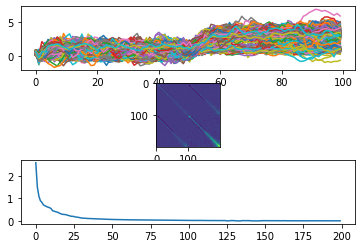

In [135]:
# 生成したpath の解析
for n_path in range(N_path):
    if np.abs(x_v_path[:, n_path]).max() > 6 or np.abs(y_v_path[:, n_path]).max() > 6:
    # if np.abs(y_v_path[:, n_path]).max() > 6:
        print('irregular = {} x_max ={} y_max ={}'.format(n_path, np.abs(x_v_path[:,n_path]).max(), np.abs(y_v_path[:,n_path]).max()))

plt.subplot(3,1,1)
plt.plot(x_v_path)
plt.plot(y_v_path)

C = np.cov(x_v_path, y_v_path)
plt.subplot(3,1,2)
plt.imshow(C)

E, V = np.linalg.eig(C)
plt.subplot(3,1,3)
plt.plot(E)
plt.show()

# 生成した path の保存
np.savez('/content/drive/My Drive/Colab Notebooks/TransferEntropy/surrogate_synthetic{}'.format(N_path), x=x_v_path, y=y_v_path, cov=C, sigma_x = [sigma_x], sigma_y = [sigma_y])

In [136]:
npz_comp=np.load('/content/drive/My Drive/Colab Notebooks/TransferEntropy/surrogate_synthetic{}.npz'.format(N_path))
print(npz_comp.files)
x_v_path = npz_comp['x']
y_v_path = npz_comp['y']
C = npz_comp['cov']
sigma2_s = npz_comp['sigma_x'][0]**2
sigma2_e = npz_comp['sigma_y'][0]**2

['x', 'y', 'cov', 'sigma_x', 'sigma_y']


In [137]:
# transfer entropy を求める
T = len(x_v_path.T[0])

lam = np.linalg.inv(C)
lam_xx = lam[:T,:T]
lam_xy = lam[:T,T:]
lam_yx = lam[T:,:T]
lam_yy = lam[T:,T:]

## yに関して周辺化
lam_x = lam_xx - lam_xy@np.linalg.inv(lam_yy)@lam_yx
## xに関して周辺化
lam_y = lam_yy - lam_yx@np.linalg.inv(lam_xx)@lam_xy

hx = np.zeros(T)
hy = np.zeros(T)
for i in range(1,T):
    ## 未来方向の周辺化
    # x
    lam_xt = lam_x[:i,:i]-lam_x[:i,i:]@np.linalg.inv(lam_x[i:,i:])@lam_x[i:,:i]
    # y
    lam_yt = lam_y[:i,:i]-lam_y[:i,i:]@np.linalg.inv(lam_y[i:,i:])@lam_y[i:,:i]
    
    hx[i-1] = 1/np.diag(lam_xt)[-1]
    hy[i-1] = 1/np.diag(lam_yt)[-1]
hx[-1] = 1/np.diag(lam_x)[-1]
hy[-1] = 1/np.diag(lam_y)[-1]

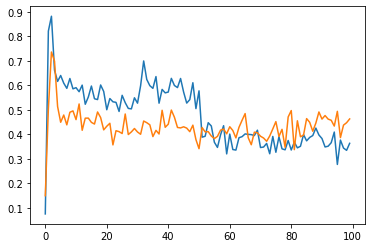

In [138]:
plt.plot(0.5*np.log(hx/sigma2_s))
plt.plot(0.5*np.log(hy/sigma2_e))
plt.show()
